##### Importing Libs

In [217]:
import pandas as pd
import sqlalchemy
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
import os
import seaborn
import matplotlib.pyplot as plt
from feature_engine.encoding import OneHotEncoder
import scikitplot as skplt

##### 1. Fetching our ABT

In [140]:
DB_PATH = os.path.dirname(os.getcwd()) + r"\spotify_ph.db"
engine = sqlalchemy.create_engine("sqlite:///" + DB_PATH)
table = "tb_abt_spotify_ph"

df_abt = pd.read_sql_table(table, engine)
df_abt.head(1)

,ts,track,artist,album,dow,tod,plays_acc,ms_acc,ms_avg,perc_skipped_acc,perc_start_trackdone_acc,perc_start_clickrow_acc,perc_start_fwdbtn_acc,perc_start_playbtn_acc,perc_start_backbtn_acc,perc_start_remote_acc,perc_start_appload_acc,perc_start_trackerror_qty_acc,perc_end_trackdone_acc,perc_end_endplay_acc,perc_end_fwdbtn_acc,perc_end_remote_acc,perc_end_logout_acc,perc_end_backbtn_acc,perc_end_paused_acc,perc_end_exit_acc,perc_end_unknown_acc,perc_end_trackerror_acc,skipped
0,2022-10-15T14:27:21Z,Dance of the Moonlight Jellies,ConcernedApe,Stardew Valley (Original Game Soundtrack),sat,afternoon,0,0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1


##### 2. Exploring

###### 2.1. Skipped Songs vs. Day of Week (DOW)

In [85]:
df_dow_skip = df_abt[["dow","skipped"]].groupby(["dow"]).mean()["skipped"].reset_index()
df_dow_skip.rename(columns={"skipped":"perc_skipped"}, inplace = True)

df_dow_count = df_abt[["dow","skipped"]].groupby(["dow"]).count()["skipped"].reset_index()
df_dow_count.rename(columns={"skipped":"plays"}, inplace = True)

df_dow = pd.merge(df_dow_count, df_dow_skip, left_on = "dow", right_on = "dow")
df_dow.sort_values(by = "plays", ascending = False, inplace = True)

df_dow

,dow,plays,perc_skipped
0,fri,4669,0.640180
4,thu,4179,0.516152
6,wed,3211,0.524759
1,mon,3159,0.454574
5,tue,3093,0.544779
2,sat,3090,0.507443
3,sun,2649,0.448849


###### 2.2. Skipped Songs vs. Time of Day (TOD)

In [91]:
df_tod_skip = df_abt[["tod","skipped"]].groupby(["tod"]).mean()["skipped"].reset_index()
df_tod_skip.rename(columns={"skipped":"perc_skipped"}, inplace = True)

df_tod_count = df_abt[["tod","skipped"]].groupby(["tod"]).count()["skipped"].reset_index()
df_tod_count.rename(columns={"skipped":"plays"}, inplace = True)

df_tod = pd.merge(df_tod_count, df_tod_skip, left_on = "tod", right_on = "tod")
df_tod.sort_values(by = "plays", ascending = False, inplace = True)

df_tod

,tod,plays,perc_skipped
0,afternoon,8581,0.521618
1,earlynight,6204,0.676015
3,morning,5549,0.520274
2,latenight,3716,0.310011


###### 2.3. Skipped Songs vs. Track, Artist, Album

In [97]:
df_track_skip = df_abt[["track","artist","album","skipped"]].groupby(["track","artist","album"]).mean()["skipped"].reset_index()
df_track_skip.rename(columns={"skipped":"perc_skipped"}, inplace = True)

df_track_count = df_abt[["track","artist","album","skipped"]].groupby(["track","artist","album"]).count()["skipped"].reset_index()
df_track_count.rename(columns={"skipped":"plays"}, inplace = True)

df_track = pd.merge(df_track_count, df_track_skip, left_on = ["track","artist","album"], right_on = ["track","artist","album"])
df_track.sort_values(by = "plays", ascending = False, inplace = True)

df_track.head(10)

,track,artist,album,plays,perc_skipped
8386,Transtorno de Estresse Pós Traumático de Apart...,Cidade Dormitório,RUÍNA ou O começo me distrai,100,0.400000
4258,Kepko,Sega Bodega,Kepko,80,0.437500
9083,Wizardry,Geo22,Wizardry,63,0.333333
375,Alchemy,Geo22,Alchemy,63,0.174603
4797,Magic,Geo22,Magic,54,0.333333
4907,Maura,Manoel Gomes,Caneta Azul,54,0.407407
1438,Caramel,Connan Mockasin,Caramel,48,0.208333
9214,You're the Only Good Thing in My Life,Cigarettes After Sex,Cry,47,0.319149
4226,K.,Cigarettes After Sex,Cigarettes After Sex,46,0.543478
5346,Márcia Ferreira,Manoel Gomes,Márcia Ferreira,45,0.688889


##### 3. Modifying Data

In [209]:
df_wip = df_abt.copy()

onehot = OneHotEncoder(variables=['dow', 'tod'])
onehot.fit(df_wip)
df_ready = onehot.transform(df_wip)

df_ready = df_ready.rename(str,axis="columns") 

df_oot = df_ready[df_ready["ts"].apply(lambda x: x.startswith("2024"))].reset_index(drop = True)
df_test = df_ready[~df_ready["ts"].apply(lambda x: x.startswith("2024"))].reset_index(drop = True)

target_test = df_test["skipped"]
target_oot = df_oot["skipped"]

to_remove = ["ts", "track", "artist", "album", "skipped"]

df_oot = df_oot[list(set(df_oot.columns) - set(to_remove))]
df_train = df_test[list(set(df_test.columns) - set(to_remove))]

df_train.head(2)

,perc_end_trackerror_acc,plays_acc,dow_thu,ms_avg,perc_end_unknown_acc,tod_afternoon,dow_tue,tod_earlynight,perc_start_trackdone_acc,dow_sun,perc_start_remote_acc,perc_start_appload_acc,ms_acc,perc_start_fwdbtn_acc,perc_end_trackdone_acc,perc_start_playbtn_acc,perc_end_paused_acc,dow_sat,perc_start_trackerror_qty_acc,perc_end_endplay_acc,dow_wed,tod_latenight,perc_end_exit_acc,tod_morning,perc_start_clickrow_acc,perc_end_remote_acc,perc_start_backbtn_acc,perc_end_backbtn_acc,perc_end_logout_acc,perc_skipped_acc,dow_fri,dow_mon,perc_end_fwdbtn_acc
0,-1.0,0,0,0.0,-1.0,1,0,0,-1.0,0,-1.0,-1.0,0,-1.0,-1.0,-1.0,-1.0,1,-1.0,-1.0,0,0,-1.0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0,0,-1.0
1,-1.0,0,0,0.0,-1.0,1,0,0,-1.0,0,-1.0,-1.0,0,-1.0,-1.0,-1.0,-1.0,1,-1.0,-1.0,0,0,-1.0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0,0,-1.0


##### 4. Modeling

###### 4.1. Decision Tree

In [198]:
X_train, X_test, y_train, y_test = train_test_split(df_train, target_test, test_size=0.2, random_state=94)

clf = tree.DecisionTreeClassifier()
clf.fit(X_train, y_train)

DecisionTreeClassifier()

In [199]:
y_train_pred = clf.predict(X_train)
y_train_proba = clf.predict_proba(X_train)

acc_train = metrics.accuracy_score(y_train, y_train_pred)
auc_train = metrics.roc_auc_score(y_train, y_train_proba[:,1])

print("Accuracy (Train): {}".format(acc_train))
print("AUC (Train): {}".format(auc_train))

Accuracy (Train): 0.8538929308285373
AUC (Train): 0.9482995718516671


In [200]:
y_test_pred = clf.predict(X_test)
y_test_proba = clf.predict_proba(X_test)

acc_test = metrics.accuracy_score(y_test, y_test_pred)
auc_test = metrics.roc_auc_score(y_test, y_test_proba[:,1])

print("Accuracy (Test): {}".format(acc_test))
print("AUC (Test): {}".format(auc_test))

Accuracy (Test): 0.5937024972855591
AUC (Test): 0.586657771481909


In [204]:
y_oot_pred = clf.predict(df_oot)
y_oot_proba = clf.predict_proba(df_oot)

acc_oot = metrics.accuracy_score(target_oot, y_oot_pred)
auc_oot = metrics.roc_auc_score(target_oot, y_oot_proba[:,1])

print("Accuracy (OOT): {}".format(acc_oot))
print("AUC (OOT): {}".format(auc_oot))

Accuracy (OOT): 0.667964946445959
AUC (OOT): 0.609087307482791


###### 4.2. Random Forest

In [201]:
rf = ensemble.RandomForestClassifier(n_estimators = 350, min_samples_leaf = 150)
rf.fit(X_train, y_train)

RandomForestClassifier(min_samples_leaf=150, n_estimators=350)

In [202]:
y_train_pred = rf.predict(X_train)
y_train_proba = rf.predict_proba(X_train)

acc_train = metrics.accuracy_score(y_train, y_train_pred)
auc_train = metrics.roc_auc_score(y_train, y_train_proba[:,1])

print("Accuracy (Train): {}".format(acc_train))
print("AUC (Train): {}".format(auc_train))

Accuracy (Train): 0.6311760234553154
AUC (Train): 0.6884959218009523


In [203]:
y_test_pred = rf.predict(X_test)
y_test_proba = rf.predict_proba(X_test)

acc_test = metrics.accuracy_score(y_test, y_test_pred)
auc_test = metrics.roc_auc_score(y_test, y_test_proba[:,1])

print("Accuracy (Test): {}".format(acc_test))
print("AUC (Test): {}".format(auc_test))

Accuracy (Test): 0.6295331161780673
AUC (Test): 0.6844836157961228


In [205]:
y_oot_pred = rf.predict(df_oot)
y_oot_proba = rf.predict_proba(df_oot)

acc_oot = metrics.accuracy_score(target_oot, y_oot_pred)
auc_oot = metrics.roc_auc_score(target_oot, y_oot_proba[:,1])

print("Accuracy (OOT): {}".format(acc_oot))
print("AUC (OOT): {}".format(auc_oot))

Accuracy (OOT): 0.75365141187926
AUC (OOT): 0.7922572178477689


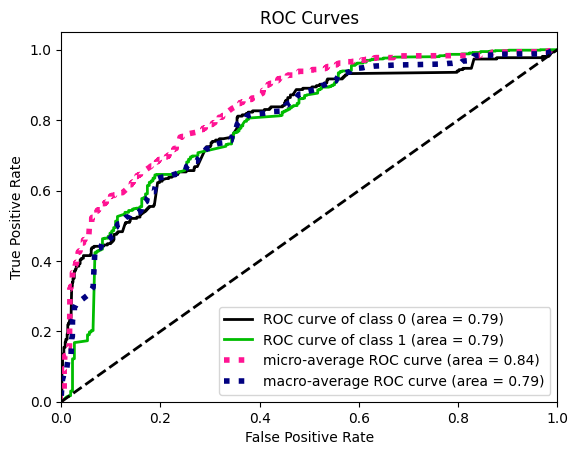

In [219]:
skplt.metrics.plot_roc(target_oot, y_oot_proba)
plt.show()

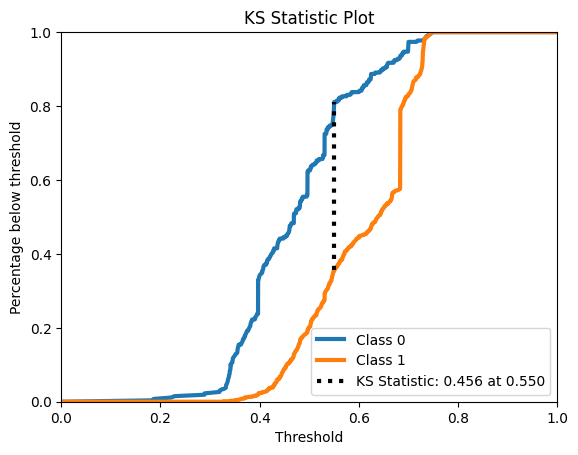

In [220]:
skplt.metrics.plot_ks_statistic(target_oot, y_oot_proba)
plt.show()

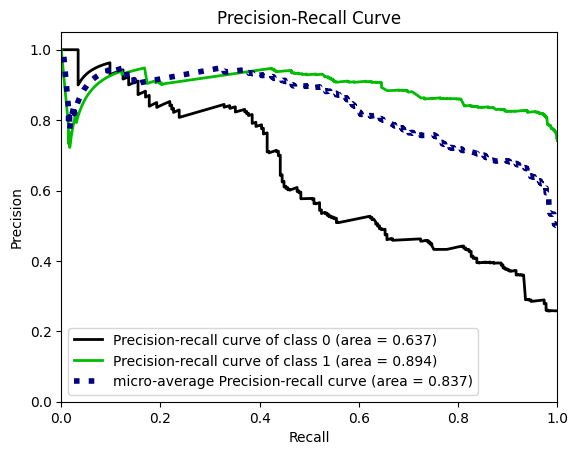

In [221]:
skplt.metrics.plot_precision_recall(target_oot, y_oot_proba)
plt.show()

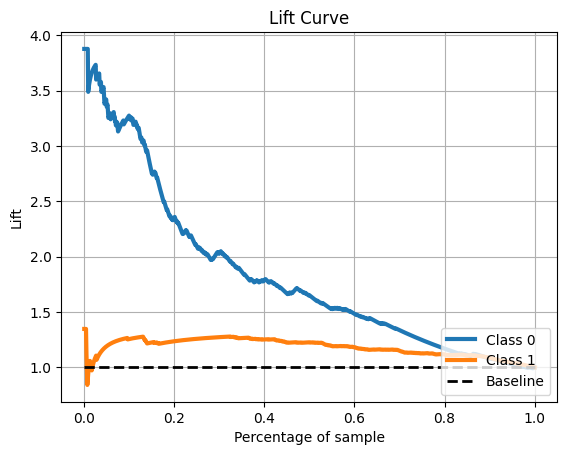

In [223]:
skplt.metrics.plot_lift_curve(target_oot, y_oot_proba)
plt.show()

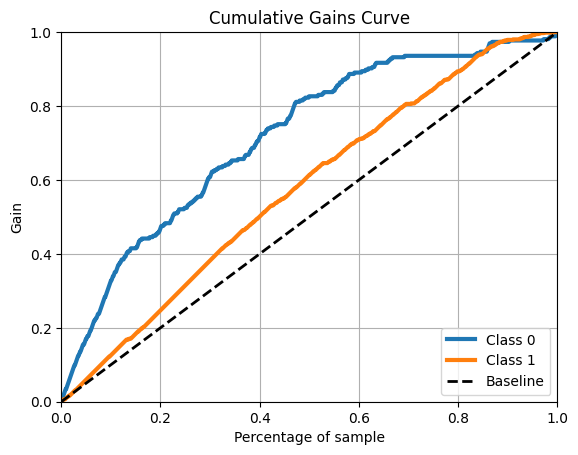

In [224]:
skplt.metrics.plot_cumulative_gain(target_oot, y_oot_proba)
plt.show()